In [2]:
import os

import numpy as np
from sklearn.utils.class_weight import compute_class_weight

from src.ppi import PPI

In [3]:
def get_project_rootpath():
    """
    获取项目根目录。此函数的能力体现在，不论当前module被import到任何位置，都可以正确获取项目根目录
    :return:
    """
    path = os.path.realpath(os.curdir)
    while True:
        for subpath in os.listdir(path):
            # PyCharm项目中，'.idea'是必然存在的，且名称唯一
            if '.idea' in subpath:
                return path
        path = os.path.dirname(path)

In [4]:
os.chdir(get_project_rootpath())
EMB_ROOT_PATH = 'data/emb/'
PPI_PATH = 'data/network/PPI-Network.txt'
DEEPWALK_EMB_ROOT_PATH = os.path.join(EMB_ROOT_PATH, 'deepwalk')
GENECOUNT_PATH = 'data/genecount.xls'
ppi = PPI(ppi_network_path=PPI_PATH, gene_count_path=GENECOUNT_PATH, k=6)

In [5]:
def dataloader(file_name, positive_gene: set, risklevel: dict):
    # file_name: emb files
    # positive_gene: 正例的gene
    # risklevel 出现了多少次的gene为positive gene

    data = file_name.strip('.emb').split('_')
    param = {i[0]: i[1:] for i in data[1:]}

    # 训练特征和label
    file_path = os.path.join(DEEPWALK_EMB_ROOT_PATH, file_name)
    with open(file_path, 'r') as f:
        data = [line.strip().split() for line in f.readlines()[1:]]
    X = [line[1:] for line in data]
    target = [1 if int(line[0]) in positive_gene else 0 for line in data]
    X = np.asarray(X, dtype=float)
    target = np.asarray(target, dtype=int)

    # 权重
    class_weight = compute_class_weight(class_weight='balanced', classes=[0, 1], y=target)
    sample_weight = [risklevel[int(line[0])] * class_weight[1]
                     if int(line[0]) in positive_gene else class_weight[0] for line in data]
    return param, X, target, sample_weight

In [6]:
from sklearn.model_selection import train_test_split

dataset = os.listdir(DEEPWALK_EMB_ROOT_PATH)[0]
params, X, y, weight = dataloader(dataset, ppi.positive_id, ppi.risk_level)
X_train, X_test, y_train, y_test, weight_train, weights_test = train_test_split(X, y,
                                                                                weight,
                                                                                test_size=0.33,
                                                                                random_state=420)

参数分为：
1. 通用参数：宏观函数控制
2. Booster参数：控制每一步的booster。一般可以调控模型的效果和计算代价。调参主要是调这个
3. 学习目标参数：控制训练目标的表现。对问题的划分主要体现在学习目标参数上。比如是分类还是回归，二分类还是多分类
# 通用参数
1. booster: gbtree和gblinear, 前者是树结构, 后者是线性模型
2. silent: 静默模式
3. nthread: 线程数, 一般设置为-1.
# Booster参数
1. n_estimator/num_boosting_rounds: 生成的最大树的数目/最大的迭代次数
2. learning_rate/eta: 每一步迭代的步长, 很重要. 太大会影响准确率, 太小了慢. 默认值是0.3,一般使用比默认值小一点.
3. gamma: 默认0.
4. subsample: 默认为1. 对每棵树, 随机采样的比例. 减小这个参数的值, 算法会更加保守避免过拟合.
5. colsample_bytree: 默认值为1. 控制每棵树随机采样的列数的占比(每一列是一个特征). 典型值: 0.5-1
6. colsample_blevel: 默认值为1. 比前一个参数更加细致, 限制到每棵树每次节点分裂的时候采样的比例.
7. max_depth: 树的最大深度, 用于控制过拟合. max_depth越大, 模型学习的更加具体. 0表示没有限制.
8. max_delta_step: 默认0, 常用0. 限制每棵树权重改变的最大步长, 设置为0时,表示没有限制. 通常不用设置,当类别不平衡时可以设置来优化逻辑回归.
9. lambda/reg_lambda: 默认值为0. 权重的L2正则化项
10. alpha/reg_alpha: 默认值为0. 权重的L1正则化项. 可以应用在很高纬度的情况下,使得算法的速度更快.
11. scale_pos_weight: 默认值为1. 类别不平衡的时候, 把这个参数设定为正值, 可以使得算法收敛的更快. 通常可以设置为 负样本/正样本.
# 学习目标参数
## objective [缺省值:`reg:linear`]
- `reg:linear`
- `reg:logistic`
- `binary:logistic`
- `binary:logitraw`
- `count:poisson`
- `multi:softmax`
- `multi:softprob`
## eval_metric
- `rmse`
- `mae`
- `logloss`
- `error`
- `merror`
- `mlogloss`
- `aur`
- `ndcg`
- `map`

In [7]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:


cv_params = {
    'n_estimators': [100, 300, 500, 700, 1000, 1250, 1500, 2000],
    'learning_rate': [0.01, 0.015, 0.025, 0.05, 0.1, 0.15, 0.3]
}

other_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth': 5,
    'gamma': 0,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0,
    'reg_lambda': 1,
    'n_estimators': 500,
    'min_child_weight': 1,
    'seed': 420
}
model = xgb.XGBClassifier(**other_params)

optimized_GBM = GridSearchCV(estimator=model,
                             param_grid=cv_params,
                             scoring=['f1', 'roc_auc', 'accuracy'],
                             refit='f1',
                             cv=5,
                             verbose=1,
                             n_jobs=-1)

optimized_GBM.fit(X_train, y_train)
evaluate_result = optimized_GBM.cv_results_

print(f'每轮迭代运行结果:{evaluate_result}')
print(f'参数的最佳取值：{optimized_GBM.best_params_}')
print(f'最佳模型得分:{optimized_GBM.best_score_}')

In [ ]:
cv_params = {
    'n_estimators': [1250, 1350, 1400, 1450, 1500, 1550, 1600, 1750],
    'learning_rate': [0.005, 0.01, 0.015, 0.02, 0.05]
}

other_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth': 5,
    'gamma': 0,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0,
    'reg_lambda': 1,
    'n_estimators': 500,
    'min_child_weight': 1,
    'seed': 420
}
model = xgb.XGBClassifier(**other_params)

optimized_GBM = GridSearchCV(estimator=model,
                             param_grid=cv_params,
                             scoring=['f1', 'roc_auc', 'accuracy'],
                             refit='f1',
                             cv=5,
                             verbose=1,
                             n_jobs=-1)

optimized_GBM.fit(X_train, y_train)
evaluate_result = optimized_GBM.cv_results_

print(f'每轮迭代运行结果:{evaluate_result}')
print(f'参数的最佳取值：{optimized_GBM.best_params_}')
print(f'最佳模型得分:{optimized_GBM.best_score_}')

In [ ]:
# 然后调试minchildweight和max_depth
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

cv_params = {
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'min_child_weight': [1, 2, 3, 4, 5, 6],
}

other_params = {
    'n_estimators': 1550,
    'learning_rate': 0.01,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth': 5,
    'gamma': 0,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0,
    'reg_lambda': 1,
    'min_child_weight': 1,
    'seed': 420
}
model = xgb.XGBClassifier(**other_params)

optimized_GBM = GridSearchCV(estimator=model,
                             param_grid=cv_params,
                             scoring=['f1', 'roc_auc', 'accuracy'],
                             refit='f1',
                             cv=5,
                             verbose=1,
                             n_jobs=-1)

optimized_GBM.fit(X_train, y_train)
evaluate_result = optimized_GBM.cv_results_

print(f'每轮迭代运行结果:{evaluate_result}')
print(f'参数的最佳取值：{optimized_GBM.best_params_}')
print(f'最佳模型得分:{optimized_GBM.best_score_}')

In [ ]:
# 将网格搜索结果转换为Pandas DataFrame
results = pd.DataFrame(evaluate_result)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

# 提取平均测试分数并重塑为矩阵形式，并分别绘制前三个子图
scores_acc = np.array(results.mean_test_accuracy).reshape(len(cv_params['min_child_weight']),
                                                          len(cv_params['max_depth']))
sns.heatmap(scores_acc, annot=True, cmap='PuBuGn', xticklabels=cv_params['max_depth'],
            yticklabels=cv_params['min_child_weight'], ax=axs[0])
axs[0].set_xlabel('Max Depth')
axs[0].set_ylabel('min_child_weight')
axs[0].set_title('Accuracy')

scores_f1 = np.array(results.mean_test_f1).reshape(len(cv_params['min_child_weight']), len(cv_params['max_depth']))
sns.heatmap(scores_f1, annot=True, cmap='PuBuGn', xticklabels=cv_params['max_depth'],
            yticklabels=cv_params['min_child_weight'], ax=axs[1])
axs[1].set_xlabel('Max Depth')
axs[1].set_ylabel('min_child_weight')
axs[1].set_title('F1 Score')

scores_auc = np.array(results.mean_test_roc_auc).reshape(len(cv_params['min_child_weight']),
                                                         len(cv_params['max_depth']))
sns.heatmap(scores_auc, annot=True, cmap='PuBuGn', xticklabels=cv_params['max_depth'],
            yticklabels=cv_params['min_child_weight'], ax=axs[2])

axs[2].set_xlabel('Max Depth')
axs[2].set_ylabel('min_child_weight')
axs[2].set_title('ROC AUC')

plt.show()


In [ ]:
cv_params = {
    'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
}

other_params = {
    'n_estimators': 1550,
    'learning_rate': 0.01,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth': 6,
    'min_child_weight': 5,
    'gamma': 0,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0,
    'reg_lambda': 1,
    'seed': 420
}
model = xgb.XGBClassifier(**other_params)

optimized_GBM = GridSearchCV(estimator=model,
                             param_grid=cv_params,
                             scoring=['f1', 'roc_auc', 'accuracy', 'r2'],
                             refit='roc_auc',
                             cv=5,
                             verbose=1,
                             n_jobs=-1)

optimized_GBM.fit(X_train, y_train)
evaluate_result = optimized_GBM.cv_results_

# print(f'每轮迭代运行结果:{evaluate_result}')
print(f'参数的最佳取值：{optimized_GBM.best_params_}')
print(f'最佳模型得分:{optimized_GBM.best_score_}')

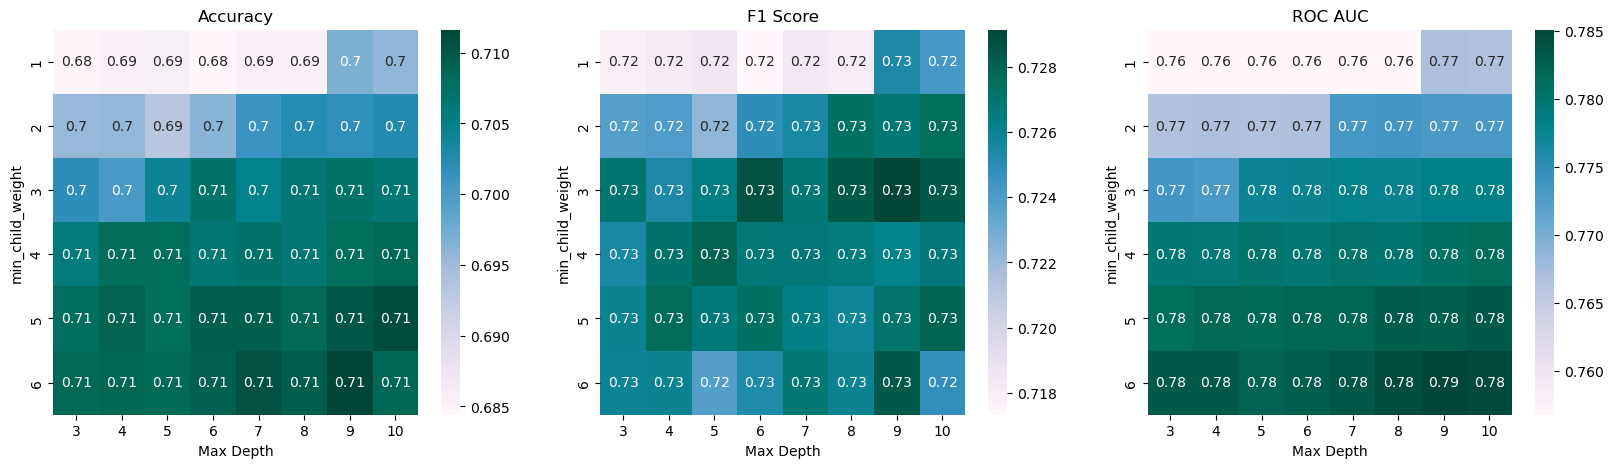

In [28]:
# 将网格搜索结果转换为Pandas DataFrame
results = pd.DataFrame(evaluate_result)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

# 提取平均测试分数并重塑为矩阵形式，并分别绘制前三个子图
scores_acc = np.array(results.mean_test_accuracy).reshape(len(cv_params['min_child_weight']),
                                                          len(cv_params['max_depth']))
sns.heatmap(scores_acc, annot=True, cmap='PuBuGn', xticklabels=cv_params['max_depth'],
            yticklabels=cv_params['min_child_weight'], ax=axs[0])
axs[0].set_xlabel('Max Depth')
axs[0].set_ylabel('min_child_weight')
axs[0].set_title('Accuracy')

scores_f1 = np.array(results.mean_test_f1).reshape(len(cv_params['min_child_weight']), len(cv_params['max_depth']))
sns.heatmap(scores_f1, annot=True, cmap='PuBuGn', xticklabels=cv_params['max_depth'],
            yticklabels=cv_params['min_child_weight'], ax=axs[1])
axs[1].set_xlabel('Max Depth')
axs[1].set_ylabel('min_child_weight')
axs[1].set_title('F1 Score')

scores_auc = np.array(results.mean_test_roc_auc).reshape(len(cv_params['min_child_weight']),
                                                         len(cv_params['max_depth']))
sns.heatmap(scores_auc, annot=True, cmap='PuBuGn', xticklabels=cv_params['max_depth'],
            yticklabels=cv_params['min_child_weight'], ax=axs[2])

axs[2].set_xlabel('Max Depth')
axs[2].set_ylabel('min_child_weight')
axs[2].set_title('ROC AUC')

plt.show()


In [7]:
cv_params = {
    'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
}

other_params = {
    'n_estimators': 1550,
    'learning_rate': 0.01,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth': 6,
    'min_child_weight': 5,
    'gamma': 0,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0,
    'reg_lambda': 1,
    'seed': 420
}
model = xgb.XGBClassifier(**other_params)

optimized_GBM = GridSearchCV(estimator=model,
                             param_grid=cv_params,
                             scoring=['f1', 'roc_auc', 'accuracy', 'r2'],
                             refit='roc_auc',
                             cv=5,
                             verbose=1,
                             n_jobs=-1)

optimized_GBM.fit(X_train, y_train)
evaluate_result = optimized_GBM.cv_results_

print(f'每轮迭代运行结果:{evaluate_result}')
print(f'参数的最佳取值：{optimized_GBM.best_params_}')
print(f'最佳模型得分:{optimized_GBM.best_score_}')

Fitting 5 folds for each of 6 candidates, totalling 30 fits
每轮迭代运行结果:{'mean_fit_time': array([488.33726273, 482.78770533, 489.66149316, 490.35739851,
       455.17990642, 326.08589416]), 'std_fit_time': array([ 9.05840913,  7.05471733,  4.08737337,  3.71061583, 63.81575388,
        2.44924538]), 'mean_score_time': array([0.26879044, 0.29714046, 0.27346864, 0.26987796, 0.21881504,
       0.18113837]), 'std_score_time': array([0.00284951, 0.0466717 , 0.01260583, 0.01240292, 0.02578875,
       0.01561433]), 'param_gamma': masked_array(data=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6],
             mask=[False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'gamma': 0.1}, {'gamma': 0.2}, {'gamma': 0.3}, {'gamma': 0.4}, {'gamma': 0.5}, {'gamma': 0.6}], 'split0_test_f1': array([0.71258278, 0.71004338, 0.71223741, 0.71081531, 0.70959088,
       0.708     ]), 'split1_test_f1': array([0.71346608, 0.70956873, 0.71313673, 0.71404513, 0.71591672,
       0.71105

In [8]:
cv_params = {
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9]
}

other_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'n_estimators': 1550,
    'learning_rate': 0.01,
    'max_depth': 6,
    'min_child_weight': 5,
    'gamma': 0.5,
    'subsample': 0.8,
    'colsample_bytree': 0.9,
    'reg_alpha': 0,
    'reg_lambda': 1,
    'seed': 420
}

model = xgb.XGBClassifier(**other_params)

optimized_GBM = GridSearchCV(estimator=model,
                             param_grid=cv_params,
                             scoring=['f1', 'roc_auc', 'accuracy', 'r2'],
                             refit='roc_auc',
                             cv=5,
                             verbose=1,
                             n_jobs=-1)

optimized_GBM.fit(X_train, y_train)
evaluate_result = optimized_GBM.cv_results_

# print(f'每轮迭代运行结果:{evaluate_result}')
print(f'参数的最佳取值：{optimized_GBM.best_params_}')
print(f'最佳模型得分:{optimized_GBM.best_score_}')

Fitting 5 folds for each of 16 candidates, totalling 80 fits
参数的最佳取值：{'colsample_bytree': 0.9, 'subsample': 0.8}
最佳模型得分:0.7737879653041334


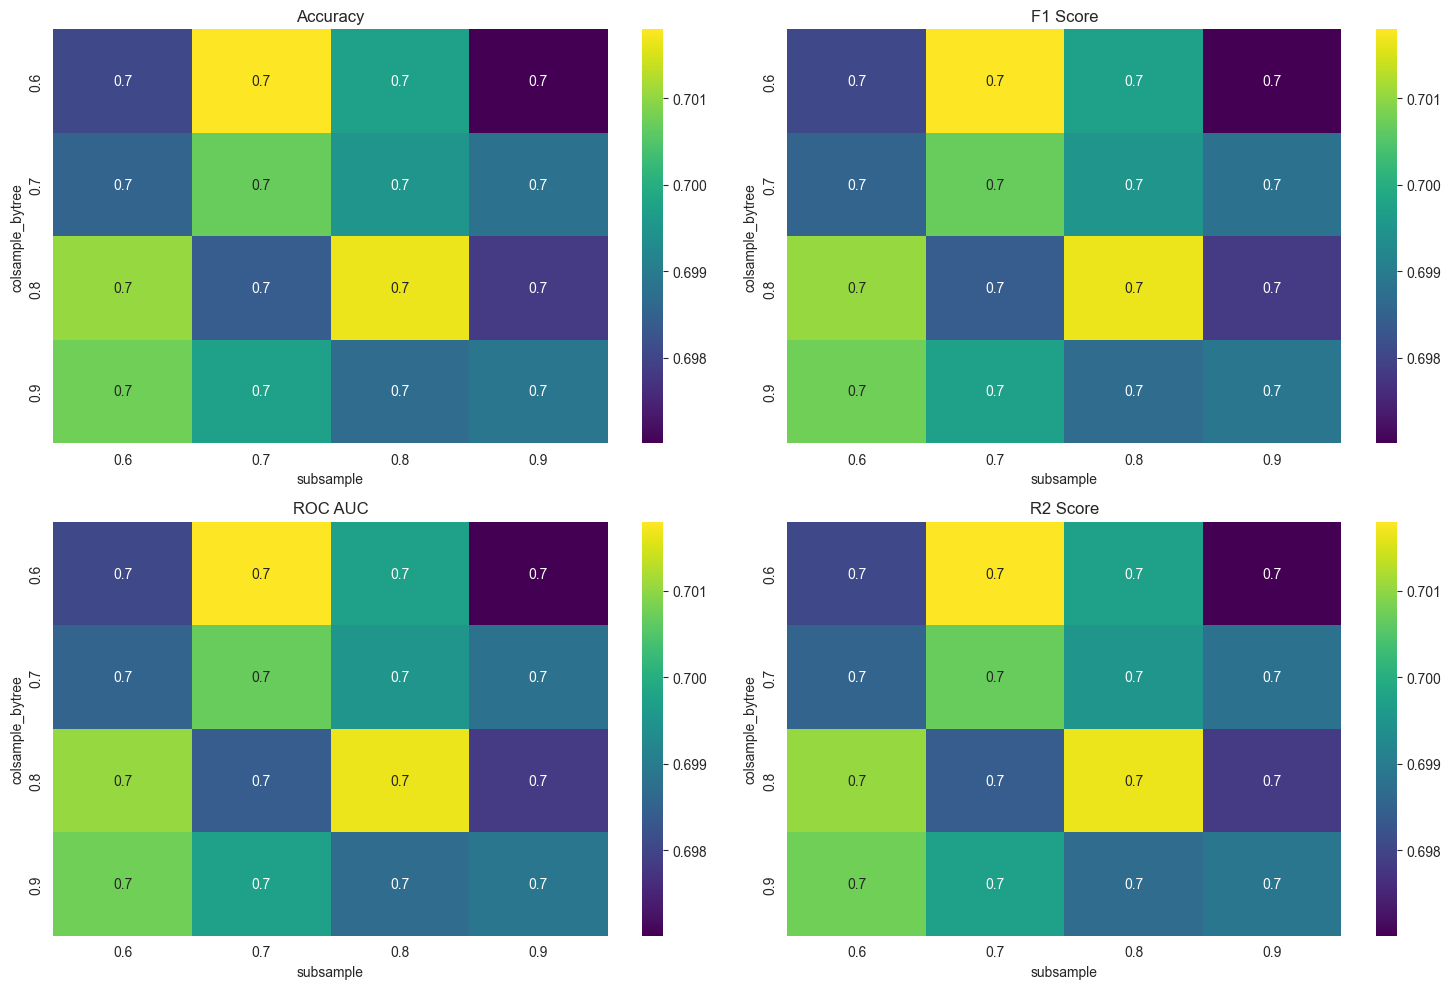

In [9]:
# 将网格搜索结果转换为Pandas DataFrame
results = pd.DataFrame(evaluate_result)

# 创建画布和子图
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# 绘制第一个子图（accuracy）
scores = np.array(results.mean_test_accuracy).reshape(len(cv_params['subsample']), len(cv_params['colsample_bytree']))
sns.heatmap(scores, annot=True, cmap='viridis', xticklabels=cv_params['subsample'],
            yticklabels=cv_params['colsample_bytree'], ax=axs[0, 0])
axs[0, 0].set_xlabel('subsample')
axs[0, 0].set_ylabel('colsample_bytree')
axs[0, 0].set_title('Accuracy')

# 绘制第二个子图（f1）
scores = np.array(results.mean_test_accuracy).reshape(len(cv_params['subsample']), len(cv_params['colsample_bytree']))
sns.heatmap(scores, annot=True, cmap='viridis', xticklabels=cv_params['subsample'],
            yticklabels=cv_params['colsample_bytree'], ax=axs[0, 1])
axs[0, 1].set_xlabel('subsample')
axs[0, 1].set_ylabel('colsample_bytree')
axs[0, 1].set_title('F1 Score')

# 绘制第三个子图（roc_auc）
scores = np.array(results.mean_test_accuracy).reshape(len(cv_params['subsample']), len(cv_params['colsample_bytree']))
sns.heatmap(scores, annot=True, cmap='viridis', xticklabels=cv_params['subsample'],
            yticklabels=cv_params['colsample_bytree'], ax=axs[1, 0])
axs[1, 0].set_xlabel('subsample')
axs[1, 0].set_ylabel('colsample_bytree')
axs[1, 0].set_title('ROC AUC')

# 绘制第四个子图（r2）
scores = np.array(results.mean_test_accuracy).reshape(len(cv_params['subsample']), len(cv_params['colsample_bytree']))
sns.heatmap(scores, annot=True, cmap='viridis', xticklabels=cv_params['subsample'],
            yticklabels=cv_params['colsample_bytree'], ax=axs[1, 1])
axs[1, 1].set_xlabel('subsample')
axs[1, 1].set_ylabel('colsample_bytree')
axs[1, 1].set_title('R2 Score')

# 调整子图之间的距离
fig.tight_layout()

# 显示图像
plt.show()


In [8]:
cv_params = {
    'reg_alpha': [0.05, 0.1, 1, 2, 3], 'reg_lambda': [0.05, 0.1, 1, 2, 3]
}

other_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'n_estimators': 1550,
    'learning_rate': 0.01,
    'max_depth': 6,
    'min_child_weight': 5,
    'gamma': 0.5,
    'subsample': 0.8,
    'colsample_bytree': 0.9,
    'reg_alpha': 0,
    'reg_lambda': 1,
    'seed': 420
}

model = xgb.XGBClassifier(**other_params)

optimized_GBM = GridSearchCV(estimator=model,
                             param_grid=cv_params,
                             scoring=['f1', 'roc_auc', 'accuracy', 'r2'],
                             refit='roc_auc',
                             cv=5,
                             verbose=1,
                             n_jobs=-1)

optimized_GBM.fit(X_train, y_train)
evaluate_result = optimized_GBM.cv_results_

# print(f'每轮迭代运行结果:{evaluate_result}')
print(f'参数的最佳取值：{optimized_GBM.best_params_}')
print(f'最佳模型得分:{optimized_GBM.best_score_}')

Fitting 5 folds for each of 25 candidates, totalling 125 fits
参数的最佳取值：{'reg_alpha': 0.1, 'reg_lambda': 1}
最佳模型得分:0.773972775318637


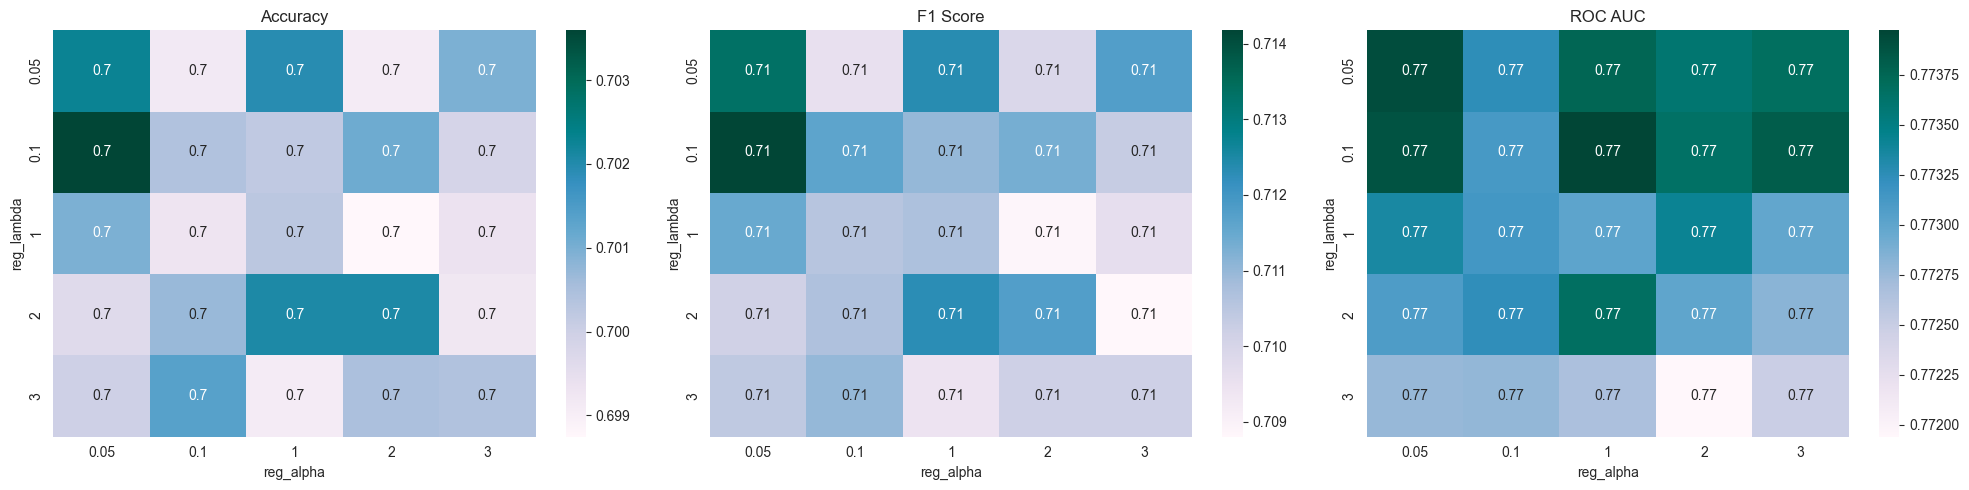

In [13]:
# 将网格搜索结果转换为Pandas DataFrame
results = pd.DataFrame(evaluate_result)

# 创建画布和子图
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

# 绘制第一个子图（accuracy）
scores = np.array(results.mean_test_accuracy).reshape(len(cv_params['reg_alpha']), len(cv_params['reg_lambda']))
sns.heatmap(scores, annot=True, cmap='PuBuGn', xticklabels=cv_params['reg_alpha'],
            yticklabels=cv_params['reg_lambda'], ax=axs[0])
axs[0].set_xlabel('reg_alpha')
axs[0].set_ylabel('reg_lambda')
axs[0].set_title('Accuracy')

# 绘制第二个子图（f1）
scores = np.array(results.mean_test_f1).reshape(len(cv_params['reg_alpha']), len(cv_params['reg_lambda']))
sns.heatmap(scores, annot=True, cmap='PuBuGn', xticklabels=cv_params['reg_alpha'],
            yticklabels=cv_params['reg_lambda'], ax=axs[1])
axs[1].set_xlabel('reg_alpha')
axs[1].set_ylabel('reg_lambda')
axs[1].set_title('F1 Score')

# 绘制第三个子图（roc_auc）
scores = np.array(results.mean_test_roc_auc).reshape(len(cv_params['reg_alpha']), len(cv_params['reg_lambda']))
sns.heatmap(scores, annot=True, cmap='PuBuGn', xticklabels=cv_params['reg_alpha'],
            yticklabels=cv_params['reg_lambda'], ax=axs[2])
axs[2].set_xlabel('reg_alpha')
axs[2].set_ylabel('reg_lambda')
axs[2].set_title('ROC AUC')


# 调整子图之间的距离
fig.tight_layout()

# 显示图像
plt.show()
